# Hand Written Character Recognition Neural Network
By: Sawyer Byrd

In [1]:
import os
import random
import pandas as pd
import numpy as np
from PIL import Image

#### Data Organization

I format the data into a matrix for easier access, organization, and computation. 

Each row represents a flattened matrix of the pixel values in each image.

There is also a "Label" column associated with each image that is it's actual class one-hot-encoded.

In [ ]:
data_dir = "//home/sawbyrd/Personal_Projects/Character Recognition Neural Network/Character_Images"

In [3]:
def convert_image(img):
    """
    Resizes an image to (80,60) and then flattens it to an array
    before appending 1 for the bias.
    Args:
        img: Image matrix (PIL Image object returned from Image.open())
    Returns:
        img: Formated image
    """
    img_r = img.resize((80, 60))    # resizing
    img = np.array(img_r).flatten() # flatten to array
    return np.append(img, 1)    # appending 1 for bias

In [4]:
def collect_data(data_dir):
    
    """
    Format of data_dir assumed to be 
    data_dir/class_name/image_name.
    
    Loops through data directory, 
    and then through each class directory.
    
    selects 5 random images from each class to use as testing data.
    
    and formats the image before adding it to the DataFrame.
    Format is based on convert_image(img).
    
    Args:
        data_dir: Directory containing the class directories
    Returns:
        train_df, test_df: Normalized and Shuffled Dataframes containing training and testing data
    """
    
    train_X = []
    train_y = []
    test_X = []
    test_y = []
    # Looping thorugh class directories
    for class_name in os.listdir(data_dir):
        class_path = os.path.join(data_dir, class_name)
        class_name = int(class_name[-2:])   # collecting class label
        
        image_files = os.listdir(class_path)    # List of directory for each img in this class
            
        # Shuffling images to pick 5 random from each class for testing
        random.shuffle(image_files)
        
        test_files = image_files[:5]
        train_files = image_files[5:]
            
        # Test loop
        for image_name in test_files:
            img_path = os.path.join(class_path, image_name)
                
            # Collecting image data, converting to array, and storing it as X
            img = Image.open(img_path).convert('L')
            test_X.append(convert_image(img))   
            
            # one-hot-encoding labels
            label = np.zeros(62)
            label[class_name-1] = 1
            label.reshape((1, 62))
            test_y.append(label)
                
        # Train loop
        for image_name in train_files:
            img_path = os.path.join(class_path, image_name)
            
            # Collecting image data, converting to array, and storing it as X
            img = Image.open(img_path).convert('L')
            train_X.append(convert_image(img))   
                
            # one-hot-encoding labels
            label = np.zeros(62)
            label[class_name-1] = 1
            label.reshape((1, 62))
            train_y.append(label)
        
    # Normalizing data
    train_X = (train_X - np.mean(train_X)) / np.std(train_X)
    test_X = (test_X - np.mean(test_X)) / np.std(test_X)  
    
    # Converting to Dataframe for ease
    train_df = pd.DataFrame(train_X)
    train_df['Labels'] = train_y
    test_df = pd.DataFrame(test_X)
    test_df['Labels'] = test_y
    
    # Shuffling the data
    train_df = train_df.sample(frac=1, random_state=42).reset_index(drop=True)
    test_df = test_df.sample(frac=1, random_state=42).reset_index(drop=True)
    
    return train_df, test_df

##### Creating Data Matricies

In [5]:
train_df, test_df = collect_data(data_dir)
print(train_df.head())    # Printing to check

          0         1         2         3         4         5         6  \
0  0.260675  0.260675  0.260675  0.260675  0.260675  0.260675  0.260675   
1  0.260675  0.260675  0.260675  0.260675  0.260675  0.260675  0.260675   
2  0.260675  0.260675  0.260675  0.260675  0.260675  0.260675  0.260675   
3  0.260675  0.260675  0.260675  0.260675  0.260675  0.260675  0.260675   
4  0.260675  0.260675  0.260675  0.260675  0.260675  0.260675  0.260675   

          7         8         9  ...      4792      4793      4794      4795  \
0  0.260675  0.260675  0.260675  ...  0.260675  0.260675  0.260675  0.260675   
1  0.260675  0.260675  0.260675  ...  0.260675  0.260675  0.260675  0.260675   
2  0.260675  0.260675  0.260675  ...  0.260675  0.260675  0.260675  0.260675   
3  0.260675  0.260675  0.260675  ...  0.260675  0.260675  0.260675  0.260675   
4  0.260675  0.260675  0.260675  ...  0.260675  0.260675  0.260675  0.260675   

       4796      4797      4798      4799      4800  \
0  0.260675  

#### Defining Functions For NN Structure

Sigmoid function and it's derivative

In [6]:
def sigmoid(z):
    """
    Computes sigmoid of the input. 
    Also clips the input to the range [-500, 500]
    Args:
        z: array type
    Returns:
        1 / 1 + np.exp(-z): sigmoid(z)
    """
    z = np.clip(z, -500, 500)
    return 1 / (1 + np.exp(-z))


def sigmoid_derivative(x):
    """
    Assumes sigmoid(x) has already been called
    Args:
        x: Output of sigmoid
    Returns:
        x * (1 - x): Derivative of the sigmoid
    """
    return x * (1 - x)


In [7]:

def create_weights(data_size, num_hid, num_out):
    """
    creates the weight matricies based on the size of the data, 
    number of neurons in the hidden layer, and number of neurons in the output layer
    Args:
        data_size (int): Size of the data input
        num_hid (int): number of hiden layer neurons
        num_out (int): dimension of output layer
    Returns:
        w_1, w_2: two weight matricies (w_1 for hidden layer, w_2 for output layer)
    """
    w_1 = np.random.randn(data_size, num_hid) * np.sqrt(1/num_hid)
    w_2 = np.random.randn(num_hid, num_out) * np.sqrt(1/num_hid)
    
    return w_1, w_2

In [8]:
# Activates a layer with dot<X, w> (Includes Bias)
def activate_layer(X, w):
    return sigmoid(np.dot(X, w))

Foreward Pass Definition

In [9]:
# A single foreward pass
def foreward_pass(X, w_1, w_2):
    a1 = activate_layer(X, w_1)
    a2 = activate_layer(a1, w_2)
    return a1, a2

Back Propogation Definition

In [10]:
def back_prop(X, y, w_1, w_2, lr): 
    """
    Performs a single foreward step and backpropagation step.
    Args:
        X (np.ndarray): Sample matrix with shape (1, data_size)
        y (np.ndarray): one-hot encoded label matrix with size (1, num_out)
        w_1 (np.ndarray): Hidden layer weight matrix with shape (data_size, num_hid)
        w_2 (np.ndarray): Output layer weight matrix with shape (num_hid, num_out)
        lr (float): learning rate

    Returns:
        w_1, w_2, loss: Updated weight matricies and loss
    """
    a1, a2 = foreward_pass(X, w_1, w_2)
    
    d_z2 = a2 - y
    d_w2 = np.dot(a1.T, d_z2)
    d_z1 = np.dot(d_z2, w_2.T) * sigmoid_derivative(a1)
    d_w1 = np.dot(X.T, d_z1)
    
    w_1 -= lr * d_w1
    w_2 -= lr * d_w2
    
    loss = np.sum(d_z2 ** 2)
    
    return w_1, w_2, loss

#### Training Structure Definition

In [11]:
def train_model(train_df, num_epochs, lr):
    """
    Trains the model
    Args:
        train_df (pandas.DataFrame): Dataframe containing training data. 
            Rows are samples, columns are features. last column is label
        num_epochs (int): Number of epochs to run
        lr (float): Learning rate
    Returns:
        w_1, w_2, loss_by_epoch: trained weight matricies and a matrix with average loss from each epoch
    """
    w_1, w_2 = create_weights(train_df.shape[1] - 1, 100, 62)
    
    loss_by_epoch = []
    
    for epoch in range(num_epochs):
        y_train = train_df['Labels']
        x_train = train_df.drop(columns=['Labels'])  
        loss = 0 
        
        for X, y in zip(x_train.values, y_train.values):
            X = X.reshape((1, len(X)))
            y = y.reshape((1, len(y)))
            w_1, w_2, l = back_prop(X, y, w_1, w_2, lr)
            loss += l
        
        if epoch % 5 == 0:   
            print('Average loss on epoch', epoch, 'is:', loss / len(x_train), '\n')
        
        loss_by_epoch.append(loss / len(x_train))
            
    return w_1, w_2, loss_by_epoch
        

#### Testing Structure Definition

In [12]:
def test_model(test_df, w_1, w_2):
    """
    Tests a trained model using test data and trained weights.
    Args:
        test_df (pandas.DataFrame): Test Dataframe. Rows are samples, columns are features. 
            last column is label (One-hot encoded)
        w_1 (np.ndarray): Weight matrix for hidden layer
        w_2 (np.ndarray): Weight matrix for output layer

    Returns:
        accuracy: The number of correct predictions divided by the total number of predictions
    """
    y_test = test_df['Labels']
    x_test = test_df.drop(columns=['Labels'])
    
    correct = 0
    for X, y in zip(x_test.values, y_test.values):
        _, a2 = foreward_pass(X, w_1, w_2)
        
        if np.argmax(a2) == np.argmax(y):
            correct += 1
    
    return correct / len(y_test)

#### Training and Testing 

In [13]:
w_1, w_2, loss_by_epoch = train_model(train_df, 100, 0.01)
accuracy = test_model(test_df, w_1, w_2)

Average loss on epoch 0 is: 1.0143083479138588 

Average loss on epoch 5 is: 0.6990183486487608 

Average loss on epoch 10 is: 0.4896589270595869 

Average loss on epoch 15 is: 0.3417661184405017 

Average loss on epoch 20 is: 0.23362287739681514 

Average loss on epoch 25 is: 0.16101797565428413 

Average loss on epoch 30 is: 0.11133690650089802 

Average loss on epoch 35 is: 0.0787804617056662 

Average loss on epoch 40 is: 0.05689905376317069 

Average loss on epoch 45 is: 0.04218588300921164 

Average loss on epoch 50 is: 0.03179432280430951 

Average loss on epoch 55 is: 0.02421319713429339 

Average loss on epoch 60 is: 0.018807130903570442 

Average loss on epoch 65 is: 0.014886093881605856 

Average loss on epoch 70 is: 0.011995750842840783 

Average loss on epoch 75 is: 0.009809568530490509 

Average loss on epoch 80 is: 0.008114012190445297 

Average loss on epoch 85 is: 0.006835049932592392 

Average loss on epoch 90 is: 0.0058194744844568625 

Average loss on epoch 95 is: 0

Printing Accuracy

In [14]:
print(f'Accuracy: {round(accuracy * 100, 2)}%')

Accuracy: 38.06%


#### Plotting Loss Graphs

just for funzies

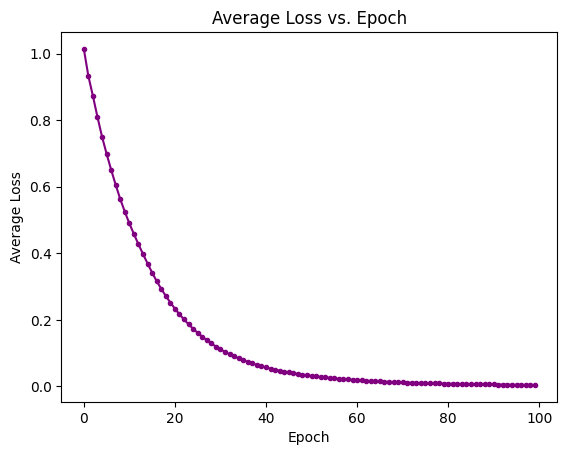

In [15]:
import matplotlib.pyplot as plt

plt.plot(range(len(loss_by_epoch)), loss_by_epoch, color='purple', marker='.', linestyle='-', label='Average Loss')
plt.xlabel('Epoch')
plt.ylabel('Average Loss')
plt.title('Average Loss vs. Epoch')

plt.show()

We can see from above that the Average loss follows a logarithmic curve as it decreases throughout each epoch.

In the graph below I changed the scale of the y-axis to logarithmic to show this.

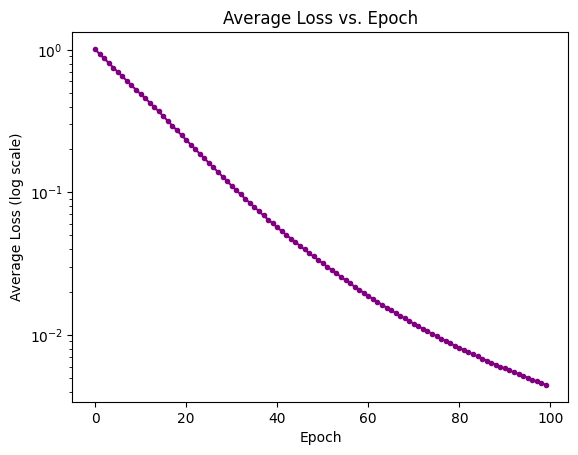

In [16]:
plt.plot(range(len(loss_by_epoch)), loss_by_epoch, color='purple', marker='.', linestyle='-', label='Average Loss')

plt.yscale('log')

plt.xlabel('Epoch')
plt.ylabel('Average Loss (log scale)')
plt.title('Average Loss vs. Epoch')

plt.show()